# Denoising Probabilistic Diffusion Model

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math
import copy
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from diffusion import DiffusionScheduler
from model import UNet, ExponentialMovingAverage
from simple_diffusion.scheduler import DDIMScheduler

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda t: (t * 2) - 1),
])

train_dataset = torchvision.datasets.ImageFolder(
    root='flowers/train',
    transform=data_transform
)

val_dataset = torchvision.datasets.ImageFolder(
    root='flowers/valid',
    transform=data_transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=True
)

mean: -0.31866533
variance: 0.25392082


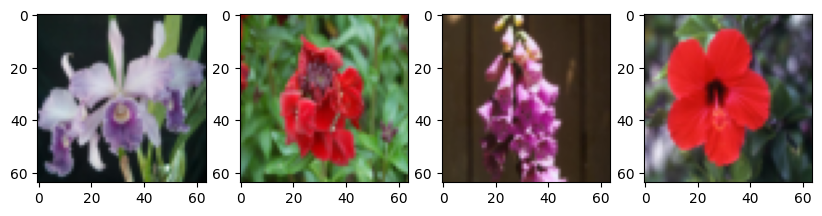

In [4]:
images = next(iter(train_loader))
images = images[0]
images = images.numpy()

print('mean:', images.mean())
print('variance:', images.var())

fig, axes = plt.subplots(figsize=(10, 4), ncols=4)
for i in range(4):
    ax = axes[i]
    ax.imshow(np.transpose((images[i] + 1) / 2, (1, 2, 0)))
plt.show()

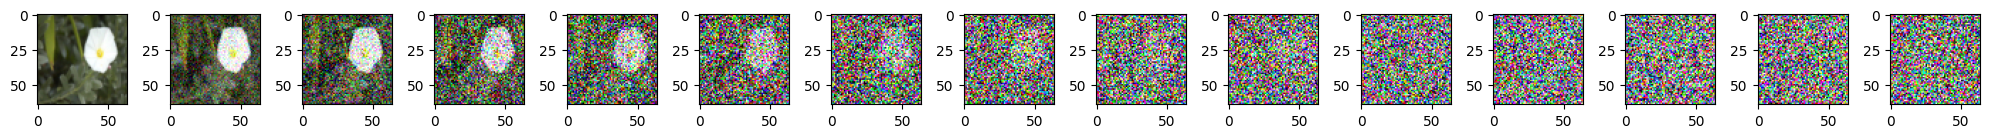

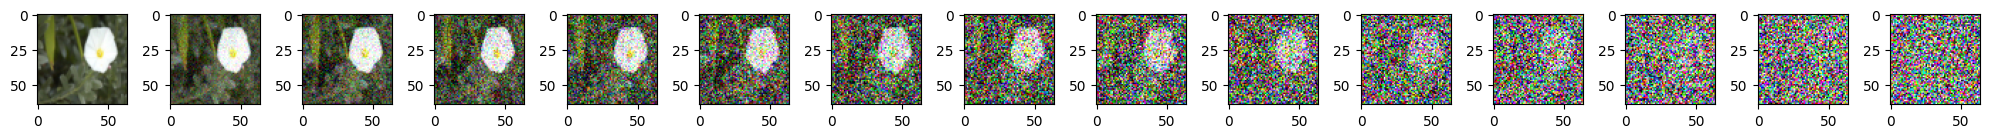

In [5]:
images = next(iter(train_loader))[0]
image = images[0].float()

T = 1000

diffusion_linear = DiffusionScheduler(T, schedule_type='linear')
diffusion_cosine = DiffusionScheduler(T, schedule_type='cosine')

num_steps = 15
image_batch = image.unsqueeze(0).expand(num_steps, -1, -1, -1)
noise = torch.randn_like(image_batch)
timesteps = torch.linspace(0, T - 1, num_steps).round().long()

noisy_images_linear = diffusion_linear.add_noise(image_batch, timesteps, noise)
noisy_images_cosine = diffusion_cosine.add_noise(image_batch, timesteps, noise)

# Plotting linear diffusion images
fig, axes_linear = plt.subplots(figsize=(20, 10), ncols=num_steps)
for i in range(num_steps):
    ax = axes_linear[i]
    noisy_image_linear = torch.clamp((noisy_images_linear[i] + 1) / 2, 0, 1)
    ax.imshow(np.transpose(noisy_image_linear.numpy(), (1, 2, 0)))
    
plt.tight_layout()
plt.show()

# Plotting cosine diffusion images
fig, axes_cosine = plt.subplots(figsize=(20, 10), ncols=num_steps)
for i in range(num_steps):
    ax = axes_cosine[i]
    noisy_image_cosine = torch.clamp((noisy_images_cosine[i] + 1) / 2, 0, 1)
    ax.imshow(np.transpose(noisy_image_cosine.numpy(), (1, 2, 0)))
    
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(5, 5))
ax.axis('off')

images = next(iter(train_loader))[0]
image = images[0].float()

num_steps = 100
image_batch = image.unsqueeze(0).expand(num_steps, -1, -1, -1)
noise = torch.randn_like(image_batch)
timesteps = torch.linspace(0, T - 1, num_steps).round().long()

noisy_images = diffusion_cosine.add_noise(image_batch, timesteps, noise)
noisy_images = torch.clamp((noisy_images + 1) / 2, 0, 1)

def update(i):
    ax.imshow(np.transpose(noisy_images[i].numpy(), (1, 2, 0)))

ani = animation.FuncAnimation(fig, update, frames=num_steps, interval=50)
HTML(ani.to_jshtml())

In [ ]:
# save animation as gif
ani.save('diffusion.gif', writer='imagemagick', fps=30)

## U-Net

![Example Image](unet.png)

In [6]:
from simple_diffusion.model import UNet

device = 'cuda' if torch.cuda.is_available() else 'cpu'
unet = UNet().to(device)
ema = ExponentialMovingAverage(copy.deepcopy(unet).requires_grad_(False))
optimizer = torch.optim.AdamW(unet.parameters(),lr=1e-3,betas=(0.9, 0.99),weight_decay=0.0)
criterion = nn.MSELoss()
epochs = 30
T = 1000
diffusion_scheduler = DDIMScheduler(beta_schedule="linear") #DiffusionScheduler(T, schedule_type='linear')
tensorboard_path="./runs/diffusion-2M-linear-1e-3"

num_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
print("Number of parameters:", num_params, device)

Number of parameters: 2291107 cuda


In [ ]:
def train(
    model,
    ema,
    diffusion_scheduler,
    train_loader,
    val_loader,
    epochs,
    device,
    optimizer,
    criterion,
    tensorboard_path="./runs/diffusion",
):
    print("Start training...")
    tb_writer = SummaryWriter(tensorboard_path)
    train_losses = []

    for epoch in tqdm(range(epochs)):
        model.train()
        
        for i, (X, y) in enumerate(train_loader):
            batch_size = X.size(0)

            timesteps = torch.randint(0, diffusion_scheduler.T, (batch_size,)).long()
            noise = torch.randn_like(X)

            noisy_images = diffusion_scheduler.add_noise(X, timesteps, noise)

            noise = noise.to(device)
            noisy_images = noisy_images.to(device)

            predicted_noise = model(noisy_images, timesteps.to(device))

            loss = criterion(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #ema.update(model)

            if i % 50 == 0:
                print(f"Epoch {epoch} Iteration {i} Loss {loss.item()}")
                train_losses.append(loss.item())

                tb_writer.add_scalar(
                    "Loss/train", loss.item(), epoch * len(train_loader) + i
                )
        
        evaluate(model, diffusion_scheduler, val_loader, device, criterion, epoch, tensorboard_path)

    print("Sampling final image")
    samples = diffusion_scheduler.generate(model)

    for i, sample in enumerate(samples):
        tb_writer.add_image("Final sample image", sample[0], i)

@torch.no_grad()
def evaluate(
    model, diffusion_scheduler, val_loader, device, criterion, epoch, tensorboard_path="./runs/diffusion"
):
    tb_writer = SummaryWriter(tensorboard_path)
    model.eval()

    total_loss = 0

    for i, (X, y) in enumerate(val_loader):
        batch_size = X.size(0)

        timesteps = torch.randint(0, diffusion_scheduler.T, (batch_size,)).long()
        noise = torch.randn_like(X)

        noisy_images = diffusion_scheduler.add_noise(X, timesteps, noise)

        noise = noise.to(device)
        noisy_images = noisy_images.to(device)

        predicted_noise = model(noisy_images, timesteps.to(device))

        loss = criterion(noise, predicted_noise)
        total_loss += loss.item()

    tb_writer.add_scalar("Loss/val", total_loss / len(val_loader), epoch)

    print(f"Epoch {epoch} Validation Loss {total_loss / len(val_loader)}")

    if epoch % 3 == 0:
        print("Sampling image")
        samples = diffusion_scheduler.generate(model)

        tb_writer.add_image("Sample image", samples[-1][0], epoch)

In [7]:
train(unet, ema, diffusion_scheduler, train_loader, val_loader, epochs, device, optimizer, criterion, tensorboard_path)

Start training...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0 Iteration 0 Loss 1.2388007640838623
Epoch 0 Iteration 50 Loss 0.05927657335996628
Epoch 0 Iteration 100 Loss 0.04130290448665619
Epoch 0 Iteration 150 Loss 0.01957211270928383
Epoch 0 Iteration 200 Loss 0.03882884979248047
Epoch 0 Iteration 250 Loss 0.042119693011045456
Epoch 0 Iteration 300 Loss 0.07537981122732162
Epoch 0 Iteration 350 Loss 0.02506614476442337
Epoch 0 Iteration 400 Loss 0.024456573650240898
Epoch 0 Validation Loss 0.05296043329872191
Sampling image



  3%|▎         | 1/30 [01:11<34:46, 71.95s/it]

Epoch 1 Iteration 0 Loss 0.036542247980833054
Epoch 1 Iteration 50 Loss 0.07079130411148071
Epoch 1 Iteration 100 Loss 0.035969629883766174
Epoch 1 Iteration 150 Loss 0.04721783101558685
Epoch 1 Iteration 200 Loss 0.04842047393321991
Epoch 1 Iteration 250 Loss 0.05102777108550072
Epoch 1 Iteration 300 Loss 0.03205173462629318
Epoch 1 Iteration 350 Loss 0.02898927591741085
Epoch 1 Iteration 400 Loss 0.04281855374574661


  7%|▋         | 2/30 [02:09<29:45, 63.76s/it]

Epoch 1 Validation Loss 0.042646597882804387
Epoch 2 Iteration 0 Loss 0.04212881252169609
Epoch 2 Iteration 50 Loss 0.06680960953235626
Epoch 2 Iteration 100 Loss 0.05965721607208252
Epoch 2 Iteration 150 Loss 0.02294716238975525
Epoch 2 Iteration 200 Loss 0.018516212701797485
Epoch 2 Iteration 250 Loss 0.08998905122280121
Epoch 2 Iteration 300 Loss 0.03181752562522888
Epoch 2 Iteration 350 Loss 0.031188679859042168
Epoch 2 Iteration 400 Loss 0.011087591759860516


 10%|█         | 3/30 [03:07<27:25, 60.94s/it]

Epoch 2 Validation Loss 0.03870217521818212
Epoch 3 Iteration 0 Loss 0.04352196678519249
Epoch 3 Iteration 50 Loss 0.015309616923332214
Epoch 3 Iteration 100 Loss 0.023389503359794617
Epoch 3 Iteration 150 Loss 0.03148987889289856
Epoch 3 Iteration 200 Loss 0.026605069637298584
Epoch 3 Iteration 250 Loss 0.05708391219377518
Epoch 3 Iteration 300 Loss 0.029633507132530212
Epoch 3 Iteration 350 Loss 0.03937125205993652
Epoch 3 Iteration 400 Loss 0.04106342792510986
Epoch 3 Validation Loss 0.03180205436924902
Sampling image



 13%|█▎        | 4/30 [04:02<25:25, 58.66s/it]

Epoch 4 Iteration 0 Loss 0.027111884206533432
Epoch 4 Iteration 50 Loss 0.035234734416007996
Epoch 4 Iteration 100 Loss 0.06495561450719833
Epoch 4 Iteration 150 Loss 0.035606905817985535
Epoch 4 Iteration 200 Loss 0.03371220827102661
Epoch 4 Iteration 250 Loss 0.02141498029232025
Epoch 4 Iteration 300 Loss 0.02446083538234234
Epoch 4 Iteration 350 Loss 0.008430540561676025
Epoch 4 Iteration 400 Loss 0.03149869292974472


 17%|█▋        | 5/30 [04:59<24:12, 58.09s/it]

Epoch 4 Validation Loss 0.03164494265085803
Epoch 5 Iteration 0 Loss 0.03196410462260246
Epoch 5 Iteration 50 Loss 0.030998919159173965
Epoch 5 Iteration 100 Loss 0.025115985423326492
Epoch 5 Iteration 150 Loss 0.014324146322906017
Epoch 5 Iteration 200 Loss 0.020678013563156128
Epoch 5 Iteration 250 Loss 0.057370543479919434
Epoch 5 Iteration 300 Loss 0.019666895270347595
Epoch 5 Iteration 350 Loss 0.02955891191959381
Epoch 5 Iteration 400 Loss 0.02963484637439251


 20%|██        | 6/30 [06:01<23:43, 59.30s/it]

Epoch 5 Validation Loss 0.03289747093087779
Epoch 6 Iteration 0 Loss 0.015730246901512146
Epoch 6 Iteration 50 Loss 0.016705889254808426
Epoch 6 Iteration 100 Loss 0.02004598081111908
Epoch 6 Iteration 150 Loss 0.05897040665149689
Epoch 6 Iteration 200 Loss 0.0365285687148571
Epoch 6 Iteration 250 Loss 0.05586084723472595
Epoch 6 Iteration 300 Loss 0.017580877989530563
Epoch 6 Iteration 350 Loss 0.029296718537807465
Epoch 6 Iteration 400 Loss 0.019935984164476395
Epoch 6 Validation Loss 0.029969686893029854
Sampling image



 23%|██▎       | 7/30 [06:54<21:55, 57.20s/it]

Epoch 7 Iteration 0 Loss 0.05991973727941513
Epoch 7 Iteration 50 Loss 0.09647710621356964
Epoch 7 Iteration 100 Loss 0.05020914226770401
Epoch 7 Iteration 150 Loss 0.02055169641971588
Epoch 7 Iteration 200 Loss 0.030440445989370346
Epoch 7 Iteration 250 Loss 0.02479824423789978
Epoch 7 Iteration 300 Loss 0.048830464482307434
Epoch 7 Iteration 350 Loss 0.05438072606921196
Epoch 7 Iteration 400 Loss 0.008316087536513805


 27%|██▋       | 8/30 [07:39<19:33, 53.33s/it]

Epoch 7 Validation Loss 0.03368068980769469
Epoch 8 Iteration 0 Loss 0.040828317403793335
Epoch 8 Iteration 50 Loss 0.02858179807662964
Epoch 8 Iteration 100 Loss 0.013719690963625908
Epoch 8 Iteration 150 Loss 0.02508571371436119
Epoch 8 Iteration 200 Loss 0.04116949066519737
Epoch 8 Iteration 250 Loss 0.025129467248916626
Epoch 8 Iteration 300 Loss 0.034620724618434906
Epoch 8 Iteration 350 Loss 0.013661118224263191
Epoch 8 Iteration 400 Loss 0.05052758380770683


 30%|███       | 9/30 [08:30<18:24, 52.60s/it]

Epoch 8 Validation Loss 0.034183455807998635
Epoch 9 Iteration 0 Loss 0.03926369175314903
Epoch 9 Iteration 50 Loss 0.03504686802625656
Epoch 9 Iteration 100 Loss 0.019607175141572952
Epoch 9 Iteration 150 Loss 0.06823285669088364
Epoch 9 Iteration 200 Loss 0.018978293985128403
Epoch 9 Iteration 250 Loss 0.02063884399831295
Epoch 9 Iteration 300 Loss 0.057502202689647675
Epoch 9 Iteration 350 Loss 0.038149937987327576
Epoch 9 Iteration 400 Loss 0.024155763909220695
Epoch 9 Validation Loss 0.02890596125059976
Sampling image



 33%|███▎      | 10/30 [09:26<17:53, 53.68s/it]

Epoch 10 Iteration 0 Loss 0.05729103833436966
Epoch 10 Iteration 50 Loss 0.001871747663244605
Epoch 10 Iteration 100 Loss 0.05289807915687561
Epoch 10 Iteration 150 Loss 0.005183134227991104
Epoch 10 Iteration 200 Loss 0.016935236752033234
Epoch 10 Iteration 250 Loss 0.010981163010001183
Epoch 10 Iteration 300 Loss 0.01573535054922104
Epoch 10 Iteration 350 Loss 0.043846480548381805
Epoch 10 Iteration 400 Loss 0.02031676471233368


 37%|███▋      | 11/30 [10:21<17:06, 54.03s/it]

Epoch 10 Validation Loss 0.029854781433151893
Epoch 11 Iteration 0 Loss 0.01912502758204937
Epoch 11 Iteration 50 Loss 0.021095559000968933
Epoch 11 Iteration 100 Loss 0.04777038097381592
Epoch 11 Iteration 150 Loss 0.012133367359638214
Epoch 11 Iteration 200 Loss 0.03796637803316116
Epoch 11 Iteration 250 Loss 0.04292134940624237
Epoch 11 Iteration 300 Loss 0.02215752750635147
Epoch 11 Iteration 350 Loss 0.01865626871585846
Epoch 11 Iteration 400 Loss 0.01428426243364811


 40%|████      | 12/30 [11:19<16:33, 55.20s/it]

Epoch 11 Validation Loss 0.02996926113533286
Epoch 12 Iteration 0 Loss 0.0362907238304615
Epoch 12 Iteration 50 Loss 0.031222982332110405
Epoch 12 Iteration 100 Loss 0.015224630944430828
Epoch 12 Iteration 150 Loss 0.02826211228966713
Epoch 12 Iteration 200 Loss 0.10639869421720505
Epoch 12 Iteration 250 Loss 0.022115131840109825
Epoch 12 Iteration 300 Loss 0.03649798035621643
Epoch 12 Iteration 350 Loss 0.0161873959004879
Epoch 12 Iteration 400 Loss 0.019800979644060135
Epoch 12 Validation Loss 0.03226697204921108
Sampling image



 43%|████▎     | 13/30 [12:15<15:41, 55.39s/it]

Epoch 13 Iteration 0 Loss 0.023965075612068176
Epoch 13 Iteration 50 Loss 0.03334151208400726
Epoch 13 Iteration 100 Loss 0.02439109794795513
Epoch 13 Iteration 150 Loss 0.024529781192541122
Epoch 13 Iteration 200 Loss 0.0758654773235321
Epoch 13 Iteration 250 Loss 0.02229723334312439
Epoch 13 Iteration 300 Loss 0.03160291537642479
Epoch 13 Iteration 350 Loss 0.055565282702445984
Epoch 13 Iteration 400 Loss 0.018512286245822906


 47%|████▋     | 14/30 [13:12<14:54, 55.91s/it]

Epoch 13 Validation Loss 0.031305937750193365
Epoch 14 Iteration 0 Loss 0.0343111976981163
Epoch 14 Iteration 50 Loss 0.10881584137678146
Epoch 14 Iteration 100 Loss 0.020485714077949524
Epoch 14 Iteration 150 Loss 0.07544185221195221
Epoch 14 Iteration 200 Loss 0.03475211560726166
Epoch 14 Iteration 250 Loss 0.020469963550567627
Epoch 14 Iteration 300 Loss 0.00838418584316969
Epoch 14 Iteration 350 Loss 0.015457953326404095
Epoch 14 Iteration 400 Loss 0.10846583545207977


 50%|█████     | 15/30 [14:11<14:12, 56.81s/it]

Epoch 14 Validation Loss 0.02984546364034311
Epoch 15 Iteration 0 Loss 0.024734463542699814
Epoch 15 Iteration 50 Loss 0.01682668924331665
Epoch 15 Iteration 100 Loss 0.038329608738422394
Epoch 15 Iteration 150 Loss 0.029747579246759415
Epoch 15 Iteration 200 Loss 0.030402062460780144
Epoch 15 Iteration 250 Loss 0.0384683720767498
Epoch 15 Iteration 300 Loss 0.017157185822725296
Epoch 15 Iteration 350 Loss 0.0556250736117363
Epoch 15 Iteration 400 Loss 0.031710557639598846
Epoch 15 Validation Loss 0.03220646790801906
Sampling image



 53%|█████▎    | 16/30 [15:10<13:25, 57.51s/it]

Epoch 16 Iteration 0 Loss 0.0354413241147995
Epoch 16 Iteration 50 Loss 0.06082179769873619
Epoch 16 Iteration 100 Loss 0.03423319756984711
Epoch 16 Iteration 150 Loss 0.020184464752674103
Epoch 16 Iteration 200 Loss 0.03610263764858246
Epoch 16 Iteration 250 Loss 0.05005247890949249
Epoch 16 Iteration 300 Loss 0.033814914524555206
Epoch 16 Iteration 350 Loss 0.020961042493581772
Epoch 16 Iteration 400 Loss 0.04949185252189636


 57%|█████▋    | 17/30 [16:05<12:20, 56.95s/it]

Epoch 16 Validation Loss 0.03290952987355503
Epoch 17 Iteration 0 Loss 0.03137081116437912
Epoch 17 Iteration 50 Loss 0.01581806130707264
Epoch 17 Iteration 100 Loss 0.010478897020220757
Epoch 17 Iteration 150 Loss 0.0768069326877594
Epoch 17 Iteration 200 Loss 0.019785365089774132
Epoch 17 Iteration 250 Loss 0.031690265983343124
Epoch 17 Iteration 300 Loss 0.030914992094039917
Epoch 17 Iteration 350 Loss 0.01605936884880066
Epoch 17 Iteration 400 Loss 0.04507755488157272


 60%|██████    | 18/30 [17:01<11:17, 56.45s/it]

Epoch 17 Validation Loss 0.03562610411944871
Epoch 18 Iteration 0 Loss 0.02311975136399269
Epoch 18 Iteration 50 Loss 0.029633209109306335
Epoch 18 Iteration 100 Loss 0.042065106332302094
Epoch 18 Iteration 150 Loss 0.05491563677787781
Epoch 18 Iteration 200 Loss 0.029265880584716797
Epoch 18 Iteration 250 Loss 0.03531999513506889
Epoch 18 Iteration 300 Loss 0.009110170416533947
Epoch 18 Iteration 350 Loss 0.037467122077941895
Epoch 18 Iteration 400 Loss 0.08507558703422546
Epoch 18 Validation Loss 0.029647971028820254
Sampling image



 63%|██████▎   | 19/30 [17:58<10:23, 56.71s/it]

Epoch 19 Iteration 0 Loss 0.014853214845061302
Epoch 19 Iteration 50 Loss 0.01630481705069542
Epoch 19 Iteration 100 Loss 0.047867801040410995
Epoch 19 Iteration 150 Loss 0.01540382020175457
Epoch 19 Iteration 200 Loss 0.022007238119840622
Epoch 19 Iteration 250 Loss 0.05807037279009819
Epoch 19 Iteration 300 Loss 0.018375825136899948
Epoch 19 Iteration 350 Loss 0.024864614009857178
Epoch 19 Iteration 400 Loss 0.01296539418399334


 67%|██████▋   | 20/30 [19:02<09:49, 58.92s/it]

Epoch 19 Validation Loss 0.028492927461719282
Epoch 20 Iteration 0 Loss 0.02397216483950615
Epoch 20 Iteration 50 Loss 0.025740772485733032
Epoch 20 Iteration 100 Loss 0.021226530894637108
Epoch 20 Iteration 150 Loss 0.01785898581147194
Epoch 20 Iteration 200 Loss 0.024633076041936874
Epoch 20 Iteration 250 Loss 0.035747479647397995
Epoch 20 Iteration 300 Loss 0.01887749508023262
Epoch 20 Iteration 350 Loss 0.016200032085180283
Epoch 20 Iteration 400 Loss 0.05544557794928551


 70%|███████   | 21/30 [20:01<08:49, 58.80s/it]

Epoch 20 Validation Loss 0.03533992257255774
Epoch 21 Iteration 0 Loss 0.026693370193243027
Epoch 21 Iteration 50 Loss 0.04477403685450554
Epoch 21 Iteration 100 Loss 0.0633356124162674
Epoch 21 Iteration 150 Loss 0.022374620661139488
Epoch 21 Iteration 200 Loss 0.026258278638124466
Epoch 21 Iteration 250 Loss 0.028978070244193077
Epoch 21 Iteration 300 Loss 0.028275860473513603
Epoch 21 Iteration 350 Loss 0.029076365754008293
Epoch 21 Iteration 400 Loss 0.026298558339476585
Epoch 21 Validation Loss 0.031521582895388395
Sampling image



 73%|███████▎  | 22/30 [20:56<07:43, 57.88s/it]

Epoch 22 Iteration 0 Loss 0.014080528169870377
Epoch 22 Iteration 50 Loss 0.03713878244161606
Epoch 22 Iteration 100 Loss 0.012622407637536526
Epoch 22 Iteration 150 Loss 0.032790906727313995
Epoch 22 Iteration 200 Loss 0.036880530416965485
Epoch 22 Iteration 250 Loss 0.019386786967515945
Epoch 22 Iteration 300 Loss 0.01663416624069214
Epoch 22 Iteration 350 Loss 0.07311560213565826
Epoch 22 Iteration 400 Loss 0.014775405637919903


 77%|███████▋  | 23/30 [21:49<06:34, 56.34s/it]

Epoch 22 Validation Loss 0.031795698280732795
Epoch 23 Iteration 0 Loss 0.020843427628278732
Epoch 23 Iteration 50 Loss 0.028162535279989243
Epoch 23 Iteration 100 Loss 0.039613671600818634
Epoch 23 Iteration 150 Loss 0.06905980408191681
Epoch 23 Iteration 200 Loss 0.07550004869699478
Epoch 23 Iteration 250 Loss 0.019482970237731934
Epoch 23 Iteration 300 Loss 0.03221495822072029
Epoch 23 Iteration 350 Loss 0.054345160722732544
Epoch 23 Iteration 400 Loss 0.025458870455622673


 80%|████████  | 24/30 [22:36<05:20, 53.47s/it]

Epoch 23 Validation Loss 0.028953033732250333
Epoch 24 Iteration 0 Loss 0.021190717816352844
Epoch 24 Iteration 50 Loss 0.025557100772857666
Epoch 24 Iteration 100 Loss 0.011999077163636684
Epoch 24 Iteration 150 Loss 0.01604083739221096
Epoch 24 Iteration 200 Loss 0.04140275716781616
Epoch 24 Iteration 250 Loss 0.013466037809848785
Epoch 24 Iteration 300 Loss 0.02066155895590782
Epoch 24 Iteration 350 Loss 0.07313324511051178
Epoch 24 Iteration 400 Loss 0.03386397287249565
Epoch 24 Validation Loss 0.030652985657350376
Sampling image



 83%|████████▎ | 25/30 [23:25<04:21, 52.28s/it]

Epoch 25 Iteration 0 Loss 0.11073499172925949
Epoch 25 Iteration 50 Loss 0.020856689661741257
Epoch 25 Iteration 100 Loss 0.009550075978040695
Epoch 25 Iteration 150 Loss 0.027313049882650375
Epoch 25 Iteration 200 Loss 0.02882320247590542
Epoch 25 Iteration 250 Loss 0.02019401267170906
Epoch 25 Iteration 300 Loss 0.031222771853208542
Epoch 25 Iteration 350 Loss 0.05939812213182449
Epoch 25 Iteration 400 Loss 0.03444082662463188


 87%|████████▋ | 26/30 [24:24<03:36, 54.19s/it]

Epoch 25 Validation Loss 0.029828980475520857
Epoch 26 Iteration 0 Loss 0.03190120682120323
Epoch 26 Iteration 50 Loss 0.035872966051101685
Epoch 26 Iteration 100 Loss 0.06408297270536423
Epoch 26 Iteration 150 Loss 0.05024543032050133
Epoch 26 Iteration 200 Loss 0.0351404994726181
Epoch 26 Iteration 250 Loss 0.030943473801016808
Epoch 26 Iteration 300 Loss 0.02483120933175087
Epoch 26 Iteration 350 Loss 0.027797624468803406
Epoch 26 Iteration 400 Loss 0.015176758170127869


 90%|█████████ | 27/30 [25:27<02:50, 56.86s/it]

Epoch 26 Validation Loss 0.030927069135941565
Epoch 27 Iteration 0 Loss 0.016551736742258072
Epoch 27 Iteration 50 Loss 0.021588165313005447
Epoch 27 Iteration 100 Loss 0.048698246479034424
Epoch 27 Iteration 150 Loss 0.05857096239924431
Epoch 27 Iteration 200 Loss 0.023361584171652794
Epoch 27 Iteration 250 Loss 0.027491286396980286
Epoch 27 Iteration 300 Loss 0.01267136912792921
Epoch 27 Iteration 350 Loss 0.02232292667031288
Epoch 27 Iteration 400 Loss 0.01574527472257614
Epoch 27 Validation Loss 0.032901871331537574
Sampling image



 93%|█████████▎| 28/30 [26:27<01:55, 57.86s/it]

Epoch 28 Iteration 0 Loss 0.012244565412402153
Epoch 28 Iteration 50 Loss 0.04577135294675827
Epoch 28 Iteration 100 Loss 0.023937541991472244
Epoch 28 Iteration 150 Loss 0.056171320378780365
Epoch 28 Iteration 200 Loss 0.06933107227087021
Epoch 28 Iteration 250 Loss 0.03050338290631771
Epoch 28 Iteration 300 Loss 0.023684954270720482
Epoch 28 Iteration 350 Loss 0.021764740347862244
Epoch 28 Iteration 400 Loss 0.032794274389743805


 97%|█████████▋| 29/30 [27:27<00:58, 58.48s/it]

Epoch 28 Validation Loss 0.03151317292716927
Epoch 29 Iteration 0 Loss 0.017209641635417938
Epoch 29 Iteration 50 Loss 0.056930821388959885
Epoch 29 Iteration 100 Loss 0.03985226899385452
Epoch 29 Iteration 150 Loss 0.0343208909034729
Epoch 29 Iteration 200 Loss 0.04796784371137619
Epoch 29 Iteration 250 Loss 0.015571641735732555
Epoch 29 Iteration 300 Loss 0.011319786310195923
Epoch 29 Iteration 350 Loss 0.026313573122024536
Epoch 29 Iteration 400 Loss 0.01427582185715437


100%|██████████| 30/30 [28:29<00:00, 56.99s/it]


Epoch 29 Validation Loss 0.029312027922759835
Sampling final image


100%|██████████| 50/50 [00:00<00:00, 103.34it/s]


In [25]:
torch.save(unet.state_dict(), 'flower_diff.pth')

In [ ]:
unet.load_state_dict(torch.load('flower_diff.pth'))

100%|██████████| 50/50 [00:00<00:00, 81.20it/s]


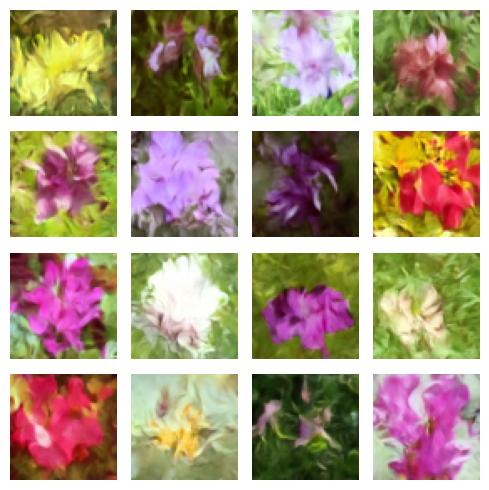

In [24]:
samples = diffusion_scheduler.generate(unet, batch_size=16, num_inference_steps=50)

fig, axes = plt.subplots(4, 4, figsize=(5, 5))

for i in range(4):
    for j in range(4):
        index = i * 4 + j
        sample = samples[-1][index].cpu()
        sample_np = np.transpose(sample.numpy(), (1, 2, 0))
        axes[i, j].imshow(sample_np)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(5, 5))
ax.axis('off')

def update(i):
    image = (samples[i].cpu().detach().numpy() + 1) / 2
    image = np.clip(image, 0, 1)
    ax.imshow(np.transpose(image, (1, 2, 0)))

samples = samples[::5, 0]
    
ani = animation.FuncAnimation(fig, update, frames=len(samples), interval=30)

HTML(ani.to_jshtml())

In [ ]:
ani.save('denoising.gif', writer='imagemagick', fps=30)